# Pyspatialml

Machine learning classification and regresssion modelling for spatial raster data.

## Description
```Pyspatialml``` is a Python module for applying scikit-learn machine learning models to raster datasets. Pyspatialml includes functions and classes for working with multiple raster datasets and performing a typical machine learning workflow consisting of extracting training data and applying the predict or predict_proba methods of scikit-learn estimators to a stack of raster datasets.

## Background

A supervised machine-learning workflow as applied to spatial raster data involves several steps:
1. Extracting training data.
2. Developing a machine learning classifier or regressor model. Pyspatialml uses scikit-learn for this purpose.
3. Performing the prediction on the raster data.

Training data consists of two components - a response feature and a set of predictors. With spatial data, the response feature is often represented by a locations when some property/state/concentration is already established. This data can be represented by point locations (e.g. arsenic concentrations soil samples), pixel locations where the pixel value represents the target of interest, or polygon features (e.g. labelled with landcover type). The predictors are represented by raster data, which contain variables that that in part may explaining the spatial distribution of the response variable (e.g., raster data representing soil types, soil properties, climatic data etc.).

## Functions and Classes 

#### The RasterStack Class

The main class that facilitates working with multiple raster datasets is the ```RasterStack``` class, which is loosely inspired by the excellent ```raster``` package in the R statistical programming language. This class takes a list of file paths to GDAL-supported raster datasets and 'stacks' them into a RasterStack class object. Because the datasets are not physically-stacked into a multi-band raster dataset, information regarding what each raster dataset means (i.e. its name) can be retained and raster datasets can easily be added or removed from the stack. Note these raster datasets need to be spatially aligned in terms of their extent, resolution and coordinate reference system. If they are not aligned, then for convenience the ```pyspatialml.utils.align_rasters``` function can be used to resample a list of raster datasets. 

Pyspatialml is built upon the ```rasterio``` Python module. Each stacked raster dataset is a rasterio DatasetReader object and contains all of the methods available in the rasterio package. Pyspatialml is also designed for working with vector data using the ```geopandas``` module.

## Example Classification

This is an example using the imagery data that is bundled with the package. This data is derived from the GRASS GIS North Carolina dataset and comprises Landsat 7 VNIR and SWIR bands along with some land cover training data that were derived from a land cover classification from an earlier date.

First, import the extract and predict functions:

In [1]:
from pyspatialml import RasterStack
from copy import deepcopy
import os
import geopandas
import rasterio.plot
import matplotlib.pyplot as plt

%matplotlib inline

### Creating a RasterStack

We are going to use a set of Landsat 7 bands contained within the pyspatialml/tests directory:

In [2]:
basedir = '../pyspatialml/tests/'
band1 = os.path.join(basedir, 'lsat7_2000_10.tif')
band2 = os.path.join(basedir, 'lsat7_2000_20.tif')
band3 = os.path.join(basedir, 'lsat7_2000_30.tif')
band4 = os.path.join(basedir, 'lsat7_2000_40.tif')
band5 = os.path.join(basedir, 'lsat7_2000_50.tif')
band7 = os.path.join(basedir, 'lsat7_2000_70.tif')
predictors = [band1, band2, band3, band4, band5, band7]

These raster datasets are aligned in terms of their extent and coordinate reference systems. We can 'stack' these into a RasterStack class so that we can perform machine learning related operations on the set of rasters:

In [3]:
stack = RasterStack(predictors)

### Extracting Training Data

Load some training data in the form of polygons, points and labelled pixels in geopandas GeoDataFrame objects. We will also generate some line geometries by converting the polygon boundaries into linestrings. All of these geometry types can be used to spatially query pixel values in a RasterStack, however each GeoDataFrame must contain only one type of geometry (i.e. either shapely points, polygons or linestrings).

In [4]:
training_py = geopandas.read_file(os.path.join(basedir, 'landsat96_polygons.shp'))
training_pt = geopandas.read_file(os.path.join(basedir, 'landsat96_points.shp'))
training_px = rasterio.open(os.path.join(basedir, 'landsat96_labelled_pixels.tif'))
training_lines = deepcopy(training_py)
training_lines['geometry'] = training_lines.geometry.boundary

Show training data points and a single raster band using numpy and matplotlib:

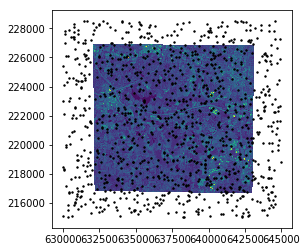

In [5]:
plt.imshow(stack.lsat7_2000_70.read(1, masked=True),
           extent=rasterio.plot.plotting_extent(stack.lsat7_2000_70))
plt.scatter(x=training_pt.bounds.iloc[:, 0],
            y=training_pt.bounds.iloc[:, 1],
            s=2, color='black')
plt.show()

Pixel values in the RasterStack can be spatially queried using the ```extract_vector``` and ```extract_raster``` methods. In addition, the ```extract_xy``` method can be used to query pixel values using a 2d array of x and y coordinates.

The ```extract_vector``` method accepts a Geopandas GeoDataFrame as the ```response``` argument. The ```field``` argument is used to indicate if values in a column in the GeoDataFrame should be extracted with the pixel values. For GeoDataFrames containing shapely point geometries, the closest pixel to each point is sampled. For shapely polygon geometries, all pixels whose centres are inside the polygon are sampled. For shapely linestring geometries, every pixel touched by the line is sampled. For all geometry types, pixel values are queries for each geometry separately. This means that overlapping polygons or points that fall within the same pixel with cause the same pixel to be sampled multiple times.

By default, the extract functions return a Geopandas GeoDataFrame of point geometries and the DataFrame containing the extracted pixels, with the column names set by the names of the raster datasets in the RasterStack. The user can also use the ```return_array=True``` argument, which instead of returning a DataFrame will return three masked numpy arrays (X, y, xy) containing the extracted pixel values, the field attribute, and the spatial coordinates of the sampled pixels. These arrays are masked arrays with nodata values in the RasterStack datasets being masked.

The ```extract_raster``` method can also be used to spatially query pixel values from a RasterStack object using another raster containing labelled pixels. This raster has to be spatially aligned with the RasterStack datasets. There is no field attribute for this method because the values of the labelled pixels are returned along with the queried pixel values, but the name of this column in the attibute can be set using the ```value_name``` argument.

In [8]:
# Create a training dataset by extracting the raster values at the training point locations:
df_points = stack.extract_vector(response=training_pt, field='id')
df_polygons = stack.extract_vector(response=training_py, field='id')
df_lines = stack.extract_vector(response=training_lines, field='id')
df_raster = stack.extract_raster(response=training_px, value_name='id')
df_points.head()

,id,lsat7_2000_10,lsat7_2000_20,lsat7_2000_30,lsat7_2000_40,lsat7_2000_50,lsat7_2000_70,geometry
0,1.0,95.0,81.0,85.0,78.0,113.0,80.0,POINT (632778.375 226867.125)
1,5.0,141.0,131.0,158.0,80.0,114.0,79.0,POINT (633490.875 226852.875)
2,1.0,74.0,60.0,54.0,73.0,78.0,44.0,POINT (639361.875 226810.125)
3,1.0,80.0,62.0,59.0,51.0,66.0,47.0,POINT (640302.375 226781.625)
4,4.0,77.0,66.0,63.0,64.0,84.0,52.0,POINT (632536.125 226710.375)


### Model Training

In [17]:
# Next we can train a logistic regression classifier:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

# define the classifier with standardization of the input features in a pipeline
lr = Pipeline(
    [('scaling', StandardScaler()),
     ('classifier', LogisticRegressionCV(n_jobs=-1))])

# fit the classifier
X = df_polygons.drop(columns=['id', 'geometry'])
y = df_polygons.id
lr.fit(X, y)

Pipeline(memory=None,
     steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))])

After defining a classifier, a typical step consists of performing a cross-validation to evaluate the performance of the model. Scikit-learn provides the cross_validate function for this purpose. In comparison to non-spatial data, spatial data can be spatially correlated, which potentially can mean that geographically proximal samples may not represent truely independent samples if they are within the autocorrelation range of some of the predictors. This will lead to overly optimistic performance measures if samples in the training dataset / cross-validation partition are strongly spatially correlated with samples in the test dataset / cross-validation partition.

In this case, performing cross-validation using groups is useful, because these groups can represent spatial clusters of training samples, and samples from the same group will never occur in both the training and test partitions of a cross-validation. An example of creating random spatial clusters from point coordinates is provided here:

In [18]:
# spatial cross-validation
from sklearn.cluster import KMeans

# create 10 spatial clusters based on clustering of the training data point x,y coordinates
clusters = KMeans(n_clusters=34, n_jobs=-1)
clusters.fit(df_polygons.geometry.bounds.iloc[:, 0:2])

# cross validate
scores = cross_validate(
  lr, X, y, groups=clusters.labels_,
  scoring='accuracy',
  cv=3,  n_jobs=1)
scores['test_score'].mean()

0.7570703471177179

### Raster Prediction

Prediction on the RasterStack is performed using the ```predict``` method. The ```estimator``` is the only required argument. If the ```file_path``` argument is not specified then the result is automatically written to a temporary file. The predict method returns an rasterio.io.DatasetReader object which is open.

Other arguments consist of ```predict_type``` can be either 'raw' to output a classification or regression result, or 'prob' to output class probabilities as a multi-band raster (a band for each class probability). In the latter case, ```indexes``` can also be supplied if you only want to output the probabilities for a particular class, or list of classes, by supplying the indices of those classes:

100%|██████████| 56/56 [00:00<00:00, 580.56it/s]


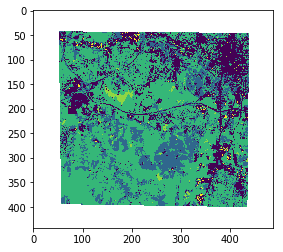

In [20]:
# prediction
result = stack.predict(estimator=lr, dtype='int16', nodata=0)
plt.imshow(result.read(1, masked=True))
plt.show()

### Sampling Tools

For many spatial models, it is common to take a random sample of the predictors to represent a single class (i.e. an environmental background or pseudo-absences in a binary classification model). The ```sample``` method is supplied in the sampling module for this purpose:

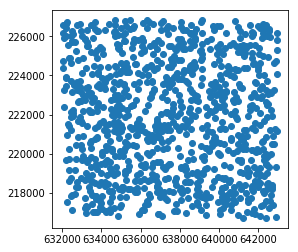

In [21]:
# sampling
# extract training data using a random sample
df_rand = stack.sample(size=1000, random_state=1)
df_rand.plot()

The sample function also enables stratified random sampling based on passing a categorical raster dataset to the strata argument. The categorical raster should spatially overlap with the dataset to be sampled, but it does not need to be of the same grid resolution.

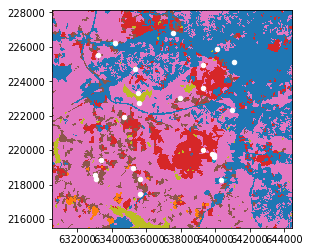

In [34]:
with rasterio.open(os.path.join(basedir, 'strata.tif')) as strata:
    df_strata = stack.sample(size=5, strata=strata, random_state=1)
    df_strata = df_strata.dropna()

    fig, ax = plt.subplots()
    ax.imshow(strata.read(1, masked=True), extent=rasterio.plot.plotting_extent(strata), cmap='tab10')
    df_strata.plot(ax=ax, markersize=20, color='white')
    plt.show()

## Vector Data Tools

In some cases, we don't need all of the training data, but rather would spatially thin a point dataset. The filter_points function performs point-thinning based on a minimum distance buffer:

In [31]:
from pyspatialml.sampling import filter_points

training_xy = training_pt.bounds.iloc[:, 2:].values
thinned_points = filter_points(xy=training_xy, min_dist=500, remove='first')
thinned_points.shape

/Users/steven/GitHub/Pyspatialml/pyspatialml/sampling.py:204: RuntimeWarning: All-NaN slice encountered
  d = np.nanmin(dm, axis=1)
/Users/steven/GitHub/Pyspatialml/pyspatialml/sampling.py:206: RuntimeWarning: invalid value encountered in greater_equal
  return xy[np.greater_equal(d, min_dist)]


(155, 2)

We can also generate random points within polygons using the get_random_point_in_polygon function. This requires a shapely POLYGON geometry as an input, and returns a shapely POINT object:

In [32]:
from pyspatialml.sampling import get_random_point_in_polygon

# generate 5 random points in a single polygon
random_points = [get_random_point_in_polygon(training_py.geometry[0]) for i in range(5)]

# convert to a GeoDataFrame
random_points = geopandas.GeoDataFrame(
  geometry=geopandas.GeoSeries(random_points))